## 1.Data Review
Store the datasets in variables with corresponding names:

* `users` — data about service users
* `rides` — data about the trips they have taken
* `subscriptions` — information about the subscription plans

In [51]:
import pandas as pd
import numpy as np
from scipy import stats as st
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(rc={'figure.figsize':(10, 7)}, style='white')

In [52]:
try:
    users = pd.read_csv('D:\docs\DS\\users_go.csv')
except:
    users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')

try:
    rides = pd.read_csv('D:\docs\DS\\rides_go.csv')
except:
    rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
    
try:
    subscriptions = pd.read_csv('D:\docs\DS\\subscriptions_go.csv')
except:
    subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

In [53]:
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


There are no missing values, column names are correct, and data types are properly assigned. At first glance, everything looks good. Let's review the information about the trips.

In [54]:
rides.info()
rides.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


There are no missing values here as well. The number of rows in the trips dataset is 11 times higher than in the users dataset, which is expected since a single customer can take multiple trips. The date information has an incorrect data type. Let's fix this before moving on to the next dataset.

In [55]:
rides['date'] = pd.to_datetime(rides['date'])
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [56]:
subscriptions.info()
subscriptions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


As stated, the service offers only two plans: with and without a subscription. The trip costs match the actual pricing information. We can now proceed with data preprocessing.

**Summary**  
During the data exploration process, we confirmed the correctness of the data formatting and the absence of missing values. Additionally, we assigned the correct data type for trip date information. All three datasets are now ready for data preprocessing.

## 2. Data Preprocessing

In the dataset containing trip information, we will create a new column, month, which will store the month of each trip. This will be useful later when calculating monthly revenue from each customer. Before proceeding, we will first assess the time range covered by the dataset. If the data spans more than two years, we will need to account for this when calculating monthly revenue.

In [57]:
rides['date'].dt.year.unique()

array([2021])

The dataset contains trip data only for the year 2021, so we can safely extract the month into a separate column.

In [58]:
rides['month'] = pd.DatetimeIndex(rides['date']).month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In the `distance` column, we will round the values to two decimal places.

In [59]:
rides['distance'] = rides['distance'].round(2)
rides

,user_id,distance,duration,date,month
0,1,4409.92,25.599769,2021-01-01,1
1,1,2617.59,15.816871,2021-01-18,1
2,1,754.16,6.232113,2021-04-20,4
3,1,2694.78,18.511000,2021-08-11,8
4,1,4028.69,26.265803,2021-08-28,8
...,...,...,...,...,...
18063,1534,3781.10,19.822962,2021-11-04,11
18064,1534,2840.42,21.409799,2021-11-16,11
18065,1534,3826.19,18.435051,2021-11-18,11
18066,1534,2902.31,16.674362,2021-11-27,11


Next, in our analysis, we will need the rounded value of the trip duration for revenue calculations. According to recommendations, we will round up to the nearest whole number and change the column's data type to int.

In [60]:
rides['duration'] = np.ceil(rides['duration']).astype('int')
rides

,user_id,distance,duration,date,month
0,1,4409.92,26,2021-01-01,1
1,1,2617.59,16,2021-01-18,1
2,1,754.16,7,2021-04-20,4
3,1,2694.78,19,2021-08-11,8
4,1,4028.69,27,2021-08-28,8
...,...,...,...,...,...
18063,1534,3781.10,20,2021-11-04,11
18064,1534,2840.42,22,2021-11-16,11
18065,1534,3826.19,19,2021-11-18,11
18066,1534,2902.31,17,2021-11-27,11


At the data exploration stage, we determined that there are no missing values in the datasets. Now, let's check the `rides` and `users` datasets for duplicates.

In [61]:
print(f"Number of duplicates in the ride data: {rides.duplicated().sum()} \n"
      f"Number of duplicates in the users data: {users.duplicated().sum()}"
     )

Number of duplicates in the ride data: 0 
Number of duplicates in the users data: 31


31 users were accidentally entered twice. We will remove fully duplicated rows from the dataset, as the given tasks rule out the possibility of duplicate user data.

In [62]:
users = users.drop_duplicates().reset_index(drop=True)
users.duplicated().sum()

0

**Summary**  
At the data preprocessing stage, we created a new column month, rounded the values in the distance and duration columns, and identified and removed 11 duplicate user records. The datasets are now ready for exploratory data analysis.

## 3. Exploratory Data Analysis
Before proceeding with data analysis, we will write functions that we will use later for plotting graphs.

In [63]:
def data_boxplot (df, column, title):    
    plt.title(title)
    df.boxplot(column=[column])
    q1 = df[column].quantile(0.25).round(1)
    q3 = df[column].quantile(0.75).round(1)
    IQR = q3 - q1
    plt.show()
    print(f"median: {df[column].median()} \n"
          f"mean: {df[column].mean().round(1)} \n"
          f"min: {df[column].min()} \n"
          f"max: {df[column].max()} \n"
          f"upper outlier threshold: {(q3 + 1.5 * IQR).round(2)} \n"
          f"lower outlier threshold: {(q1 - 1.5 * IQR).round(2)} \n"
          f"Q1: {q1} \n"
          f"Q3: {q3}"
         )

def data_hist (df, column, title, xlabel, ylabel, bins, range_ox):    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    df[column].hist(bins = bins, range = range_ox)
    plt.show()
    q1 = df[column].quantile(0.25).round(1)
    q3 = df[column].quantile(0.75).round(1)
    IQR = q3 - q1
    print(f"медиана: {df[column].median()} \n"
          f"среднее: {df[column].mean().round(1)} \n"
          f"min: {df[column].min()} \n"
          f"max: {df[column].max()} \n"
          f"upper outlier threshold: {(q3 + 1.5 * IQR).round(2)} \n"
          f"lower outlier threshold: {(q1 - 1.5 * IQR).round(2)}"
         )

To understand the specifics of how the service operates, we will analyze the data based on key metrics: city, subscription status, age, trip distance, and trip duration.

### 3.1. CITY
Let's examine which cities our users come from and how they are distributed across different locations.

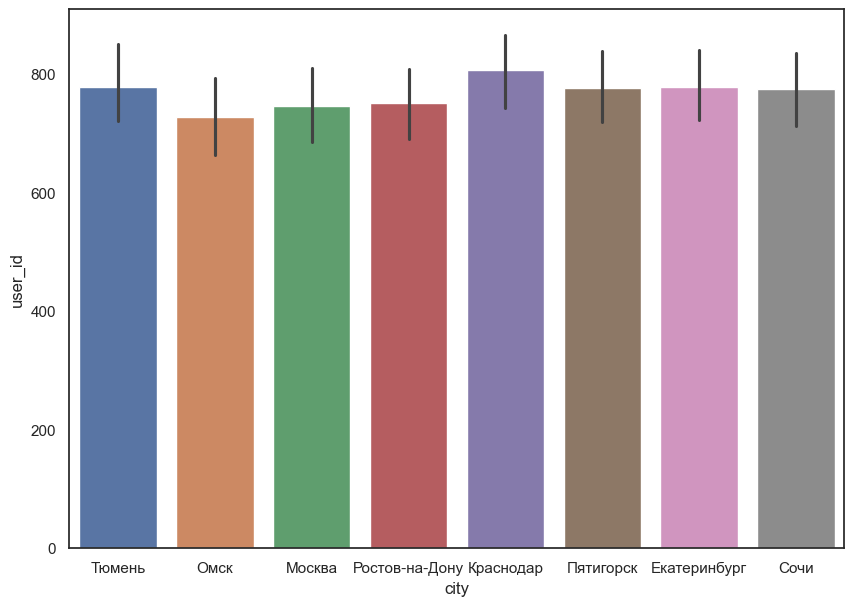

,user_id
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


In [64]:
sns.barplot(data=users, x='city', y='user_id', hue='city')
sns.set(font_scale=1.2)
plt.show()

users.pivot_table(index='city', 
                  values='user_id', 
                  aggfunc='count').sort_values('user_id', ascending=False)

The service is most in demand in cities with a longer warm season—and, surprisingly, in Yekaterinburg. We can assume that this city has particularly favorable conditions for the service's development. However, since analyzing user loyalty by region is beyond the scope of this study, we will leave it at that assumption for now.

### 3.2. SUBSCRIPTION TYPE
We will create a summary table and a chart to assess the ratio of non-subscribers to subscribers.

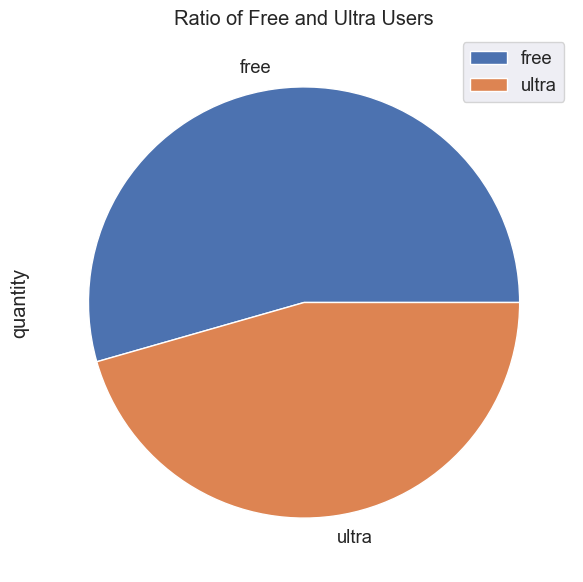

,quantity,%_of_total
subscription_type,,
free,835,54.4
ultra,699,45.6


In [65]:
subcribtion_pivot = (users.pivot_table(index='subscription_type', 
                  values='user_id', 
                  aggfunc='count').sort_values('user_id', ascending=False)
                     )

subcribtion_pivot.rename(columns = {'user_id': 'quantity'}, inplace=True)
subcribtion_pivot['%_of_total'] = (subcribtion_pivot['quantity'] / len(users) * 100).round(1)

subcribtion_pivot.plot(y='quantity', kind='pie')
plt.title('Ratio of Free and Ultra Users')
plt.show()

subcribtion_pivot

There are fewer subscribed users, and the majority ride without a subscription. However, this is not critical, considering that both groups are large enough for statistical analysis.

### 3.3. AGE
We will visualize the age distribution of users using a histogram by calling the previously written function data_hist.

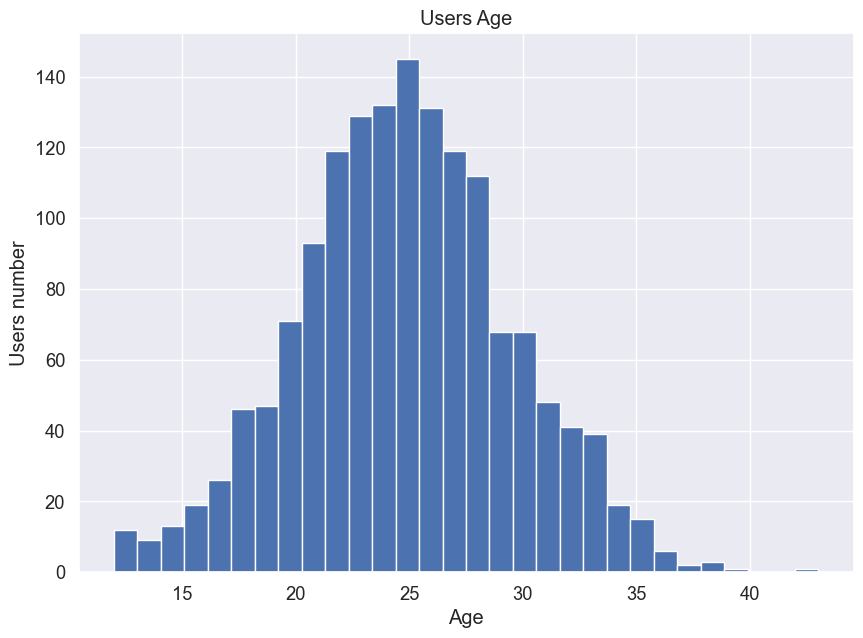

медиана: 25.0 
среднее: 24.9 
min: 12 
max: 43 
upper outlier threshold: 37.0 
lower outlier threshold: 13.0


In [66]:
data_hist(users, 'age', 'Users Age', 
          'Age', 'Users number', 
          30, (users['age'].min(), users['age'].max())
         )

The median almost coincides with the mean, indicating a normal age distribution among users. The majority of riders fall within the 22-28 age range.

### 3.4. DISTANCE
We will visualize the distribution of trip distances using the previously written function data_boxplot.

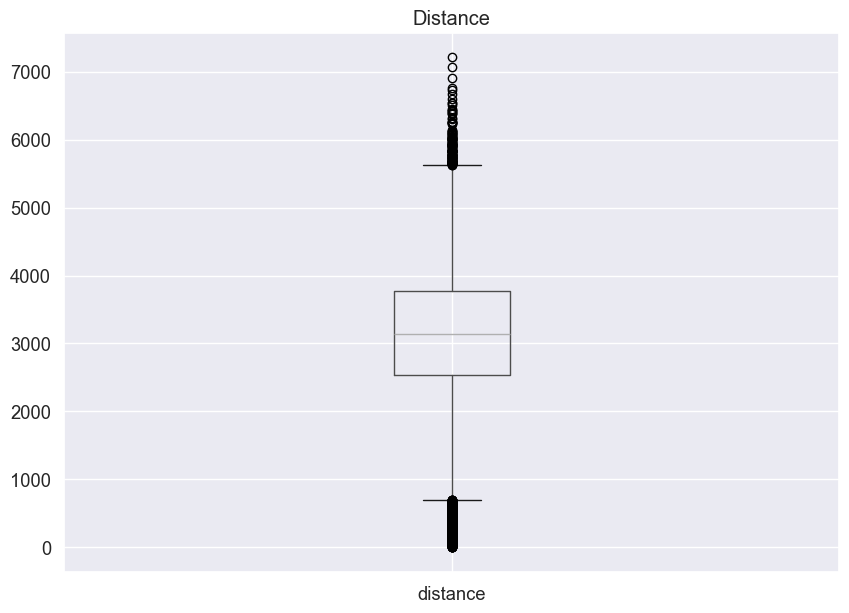

median: 3133.61 
mean: 3070.7 
min: 0.86 
max: 7211.01 
upper outlier threshold: 5625.7 
lower outlier threshold: 693.7 
Q1: 2543.2 
Q3: 3776.2


In [67]:
data_boxplot(rides, 'distance', 'Distance')

The graph shows a dense strip of outliers: there are very short trips where something might have gone wrong (possibly a scooter malfunction or the user deciding to cancel the ride), as well as trips covering distances greater than 5.6 kilometers. The gap between the median and the mean is more pronounced.

In this study, we will not exclude extreme values. However, we will check whether these outliers are related to the month of the trip. It is possible that people prefer longer rides in the summer compared to autumn or winter.

In [68]:
print(f"Number of extremely long trips: {len(rides.query('distance > 5625.7'))} \n"
      f"Share of total trips: {len(rides.query('distance > 5625.7')) / rides.shape[0] * 100} \n" 
      f"Median distance by month:"
     )
rides.query('distance > 5625.7').pivot_table(index='month', 
                                             values='distance', 
                                             aggfunc=['median', 'count'])

Number of extremely long trips: 126 
Share of total trips: 0.6973655080805844 
Median distance by month:


,median,count
,distance,distance
month,,
1,5801.695,14
2,6112.270,10
3,5868.240,8
4,5830.545,10
5,5916.955,10
6,5758.300,8
7,6115.130,10
8,5800.730,7


Long trips are rare, accounting for less than 1% of all rides, and their distance is completely independent of the season. Even in southern regions, where riding a scooter in winter is uncomfortable, there are still daring users. Now, let's take a look at extremely short trips.

In [69]:
print(f"Number of extremely short trips: {len(rides.query('distance < 693.7'))} \n"
      f"Share of total trips: {len(rides.query('distance < 693.7')) / rides.shape[0] * 100} \n" 
      f"Median distance by month:"
     )
rides.query('distance < 693.7').pivot_table(index='month', 
                                             values='distance', 
                                             aggfunc=['median', 'count'])

Number of extremely short trips: 910 
Share of total trips: 5.036528669470887 
Median distance by month:


,median,count
,distance,distance
month,,
1,402.270,68
2,420.425,78
3,416.750,89
4,488.410,75
5,387.580,66
6,474.400,63
7,402.040,67
8,384.580,90


There are significantly more ultra-short trips (already 5% of the total number of trips), and, as with long distances, there is no apparent seasonal dependence. Most likely, short trips are related to technical issues, which are not considered in our dataset.

### 3.5. DURATION
It is natural to assume that if there are outliers in trip distances, there should also be outliers in trip duration. Let's visualize the data distribution.

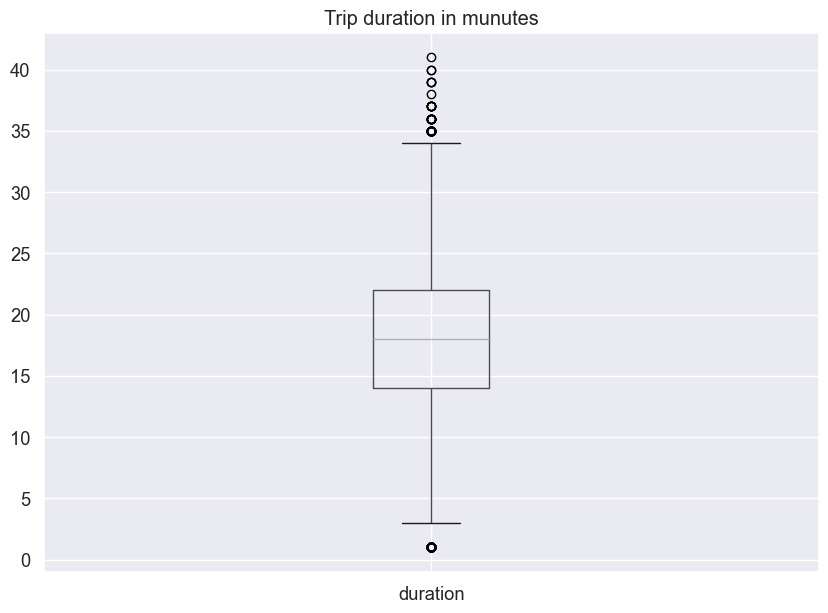

median: 18.0 
mean: 18.3 
min: 1 
max: 41 
upper outlier threshold: 34.0 
lower outlier threshold: 2.0 
Q1: 14.0 
Q3: 22.0


In [70]:
data_boxplot(rides, 'duration', 'Trip duration in munutes')

In [71]:
print(f"Number of extremely long trips: {len(rides.query('duration > 34'))} \n"
      f"Share of total trips: {len(rides.query('duration > 34')) / rides.shape[0] * 100} \n \n"
      f"Number of extremely short trips: {len(rides.query('duration < 2'))} \n"
      f"Share of total trips: {len(rides.query('duration < 2')) / rides.shape[0] * 100} \n"
     )

Number of extremely long trips: 75 
Share of total trips: 0.4150985167146336 
 
Number of extremely short trips: 95 
Share of total trips: 0.5257914545052026 



There are only **75** extremely long-duration trips compared to **126** extremely long-distance trips. Clearly, some of our users enjoy high-speed rides over long distances. Hopefully, they remember to wear helmets and follow traffic rules (:

The difference between short-distance and short-duration trips is even more significant: **910** vs. **95**, respectively. It is likely that not all users who changed their minds about riding were able to quickly cancel the trip in the app. Later, we will examine how many of them returned to use the service again and whether any of them decided to subscribe.

**Summary**
Through our exploratory data analysis, we have established that:
1. The service has more clients in regions with longer warm seasons, as well as in Yekaterinburg, where favorable conditions for service development may exist.
2. The number of subscribed users is 16% lower than the number of non-subscribed users.
3. The average (which is also the median) age of our users is 25 years, with the majority being between 22 and 28 years old.
4. The median trip distance is 3.1 km, but we observe ultra-short trips (less than half a kilometer) as well as extremely long trips (over 5.6 km).
5. On average, trip duration is 18 minutes, with the majority of trips lasting between 14 and 22 minutes.

## 4. Merging Data and Comparing Metrics
### 4.1. Creating Datasets for Statistical Analysis
Let's prepare three datasets:

* `all_users` – a complete dataset with all user information, including trips, tariffs, etc.
* `ultra_users` – a dataset for users with a subscription.
* `free_users` – a dataset for users without a subscription.

In [72]:
all_users = rides.merge(users, on='user_id', how='outer')
all_users = all_users.merge(subscriptions, on='subscription_type', how='outer')
all_users

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.92,26,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.59,16,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.16,7,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.78,19,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.69,27,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,3781.10,20,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
18064,1534,2840.42,22,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
18065,1534,3826.19,19,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
18066,1534,2902.31,17,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


Let's verify the result of merging the tables: the number of rows in the original rides table should match the number of rows in the newly created `all_users` table. Additionally, we will check if any missing values have appeared in the new dataset.

In [73]:
print(f"Number of rows in dataset rides: {len(rides)} \n"
      f"Number of rows in dataset all_users: {len(all_users)} \n"
      f"Number of missing values in dataset all_users: \n{all_users.isna().sum()}")

Number of rows in dataset rides: 18068 
Number of rows in dataset all_users: 18068 
Number of missing values in dataset all_users: 
user_id              0
distance             0
duration             0
date                 0
month                0
name                 0
age                  0
city                 0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


All rows are in place, and no missing values have appeared—the table merge was successful.

In [74]:
ultra_users = all_users.query("subscription_type == 'ultra'")
ultra_users

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.92,26,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.59,16,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.16,7,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.78,19,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.69,27,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,3973.05,25,2021-08-29,8,Оксана,22,Москва,ultra,6,0,199
6496,699,3288.70,16,2021-09-12,9,Оксана,22,Москва,ultra,6,0,199
6497,699,3076.16,15,2021-09-26,9,Оксана,22,Москва,ultra,6,0,199
6498,699,4707.85,16,2021-10-17,10,Оксана,22,Москва,ultra,6,0,199


In [75]:
free_users = all_users.query("subscription_type == 'free'")
free_users

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.69,15,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.93,17,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.43,21,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.91,10,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.38,18,2021-02-14,2,Айдар,22,Омск,free,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,3781.10,20,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
18064,1534,2840.42,22,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
18065,1534,3826.19,19,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
18066,1534,2902.31,17,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


We have obtained three tables: one containing information on all 18,068 rides, another with data on 6,500 rides from subscribed users, and a third with data on 11,568 rides from non-subscribed users. Earlier, we calculated that there are slightly more non-subscribed users—835 compared to 699. However, we won’t rush to conclusions until we analyze ride duration and the profitability of each group.

### 4.2. Comparison of Data Distributions
First, let's compare the ride distance achievements of Ultra and Free users.

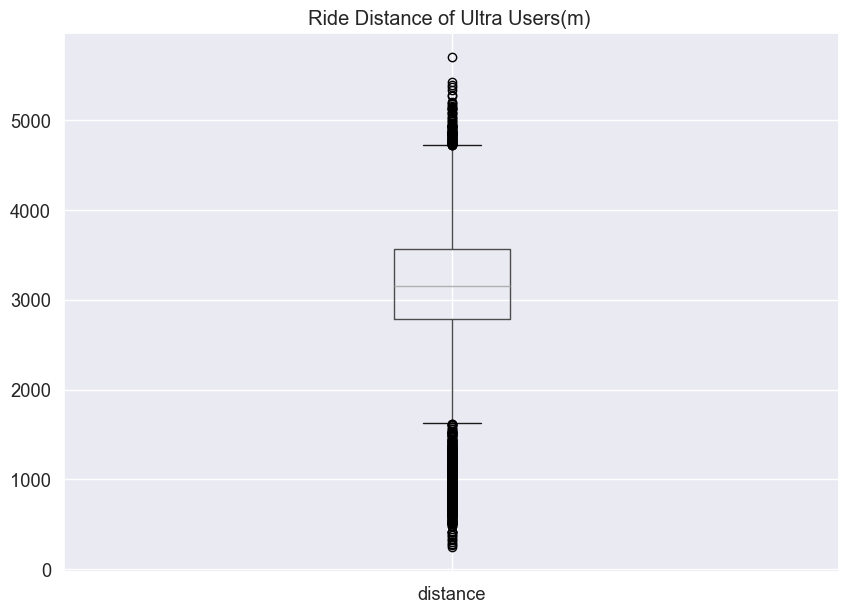

median: 3148.6400000000003 
mean: 3115.4 
min: 244.21 
max: 5699.77 
upper outlier threshold: 4723.4 
lower outlier threshold: 1622.6 
Q1: 2785.4 
Q3: 3560.6


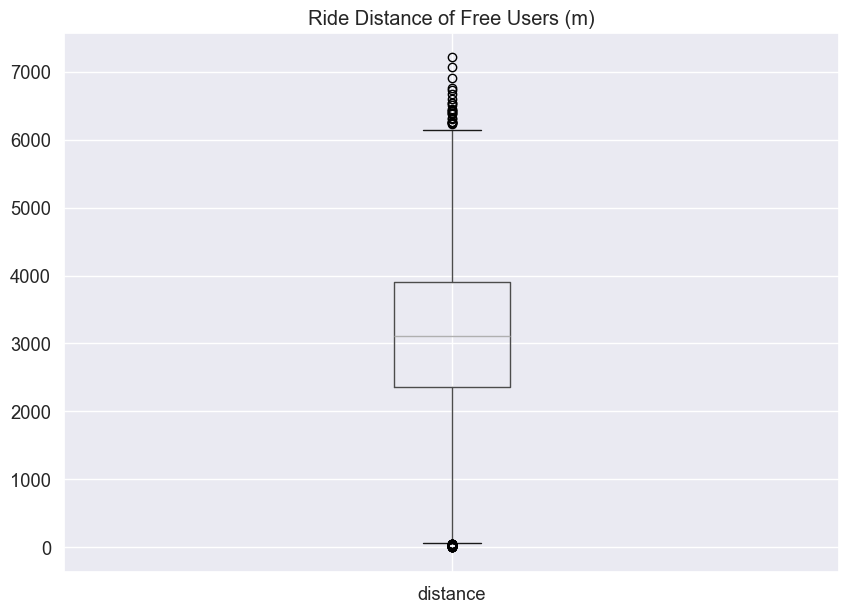

median: 3114.6499999999996 
mean: 3045.5 
min: 0.86 
max: 7211.01 
upper outlier threshold: 6214.35 
lower outlier threshold: 57.95 
Q1: 2366.6 
Q3: 3905.7


In [76]:
data_boxplot(ultra_users, 'distance', 'Ride Distance of Ultra Users(m) ')

data_boxplot(free_users, 'distance', 'Ride Distance of Free Users (m)')

The average ride distance is roughly the same for users in both groups. However, based on the first quartile, users who decided to become regular customers are less likely to abandon their ride shortly after starting (1,623 meters vs. 58 meters). The shortest distance considered an outlier in the subscription group (244 meters) is almost twice the lower outlier threshold in the non-subscription group.

Subscribed users are more committed to their rides, whereas non-subscribed users tend to either cancel early or travel longer distances when they do ride. To better illustrate this comparison, we will display both graphs on the same plot.

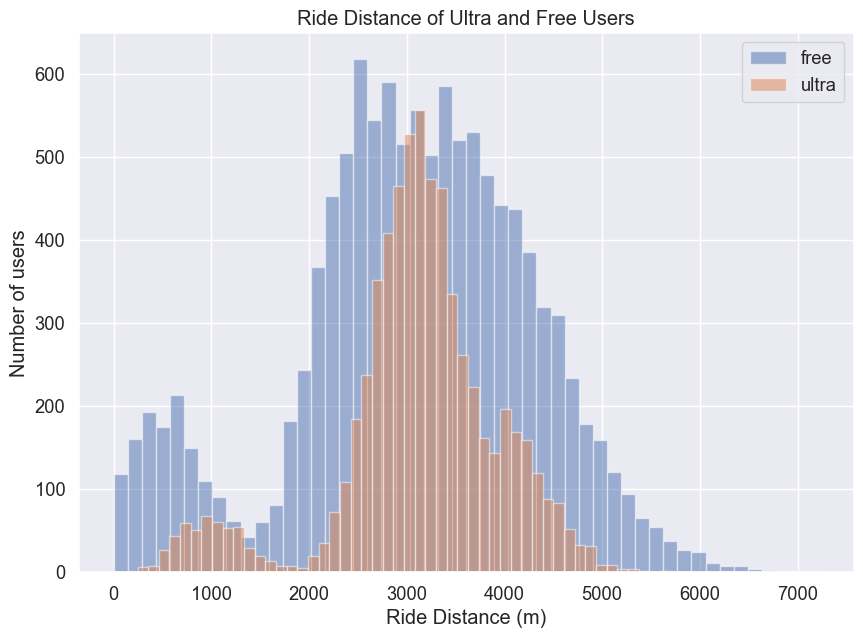

In [77]:
free_users['distance'].hist(alpha=0.5, label='free', bins = 50)
ultra_users['distance'].hist(alpha=0.5, label='ultra', bins = 50)

plt.title('Ride Distance of Ultra and Free Users')
plt.xlabel('Ride Distance (m)')
plt.ylabel('Number of users')
plt.legend()
plt.show()

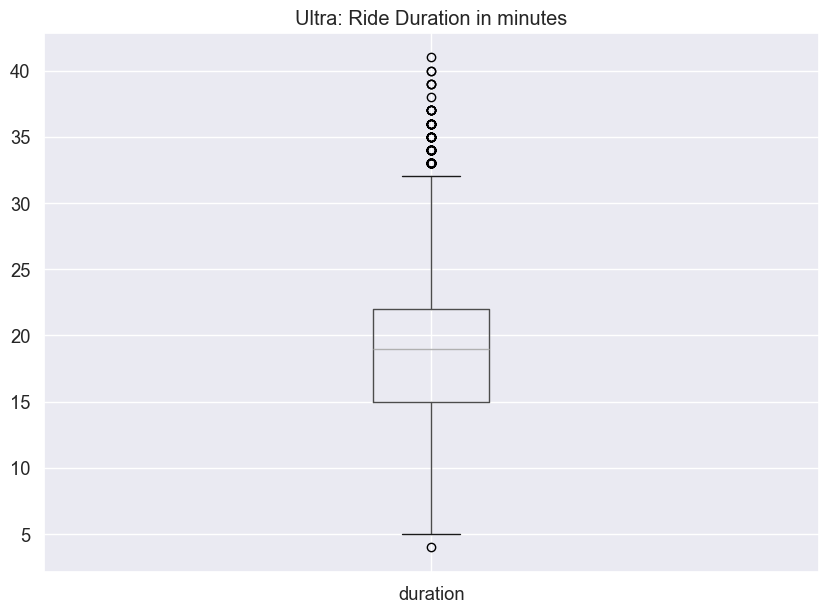

median: 19.0 
mean: 19.0 
min: 4 
max: 41 
upper outlier threshold: 32.5 
lower outlier threshold: 4.5 
Q1: 15.0 
Q3: 22.0


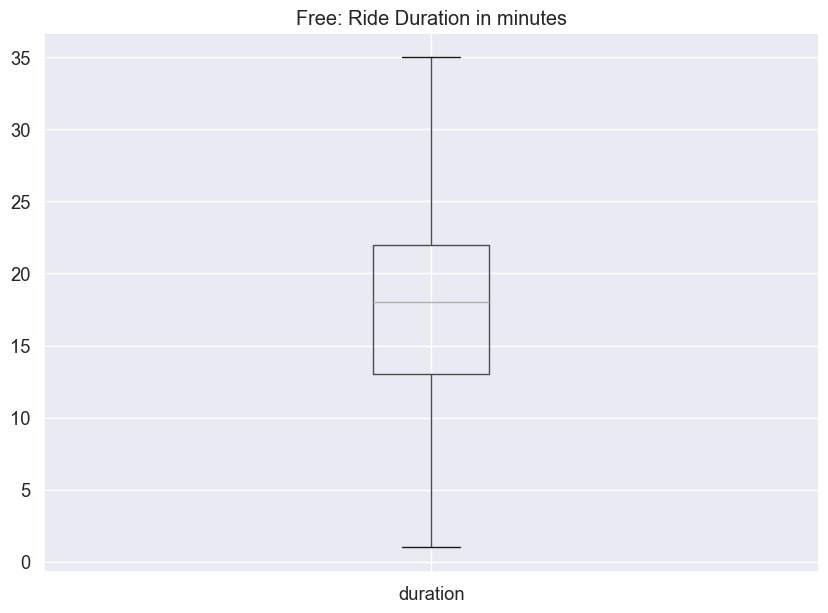

median: 18.0 
mean: 17.9 
min: 1 
max: 35 
upper outlier threshold: 35.5 
lower outlier threshold: -0.5 
Q1: 13.0 
Q3: 22.0


In [78]:
data_boxplot(ultra_users, 'duration', 'Ultra: Ride Duration in minutes')

data_boxplot(free_users, 'duration', 'Free: Ride Duration in minutes')

On average, rides by subscription users last one minute longer, which is expected since they tend to cover greater distances. We also previously noted that there are 95 extremely short rides lasting no more than 2 minutes. As seen in the graphs above, these short trips are primarily made by users without a subscription.

To better illustrate the difference, let's visualize both distributions on the same plot.



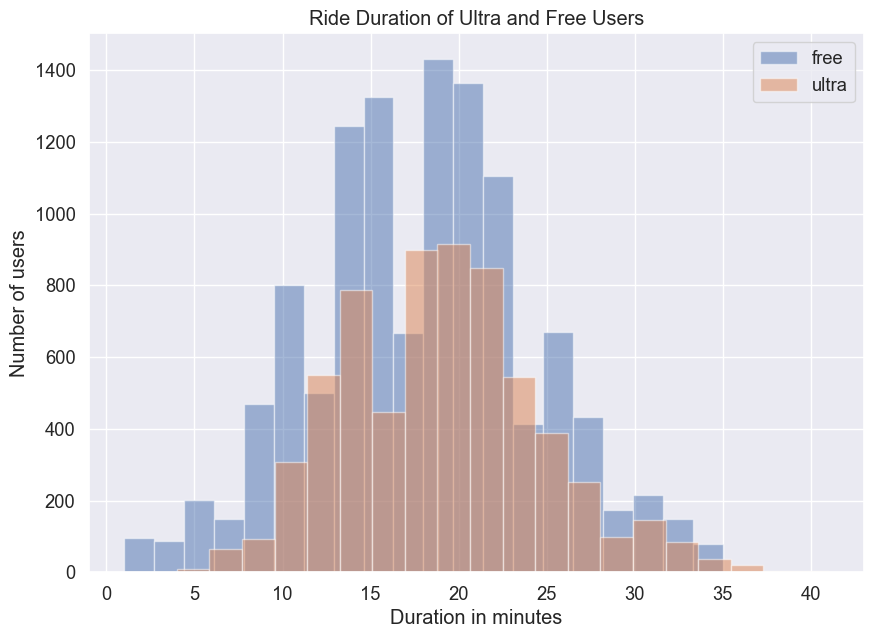

In [79]:
free_users['duration'].hist(alpha=0.5, label='free', bins = 20)
ultra_users['duration'].hist(alpha=0.5, label='ultra', bins = 20)

plt.title('Ride Duration of Ultra and Free Users')
plt.xlabel('Duration in minutes')
plt.ylabel('Number of users')
plt.legend()
plt.show()

**Summary**  
For statistical data analysis, we prepared three datasets containing full information about users and their trips: one general dataset and two separate ones for subscribed and non-subscribed users. By comparing data distributions across these groups, we established that having a subscription leads to longer distances and durations of trips.

## 5. Revenue Calculation
We will create a summary table aggregating trip data based on the all_users dataframe. This table will include the total distance traveled, the number of trips, and the total duration for each user per month. Additionally, we will calculate the monthly revenue for each user.

In [80]:
all_users_pivot = (all_users.pivot_table(index=['user_id', 'month'], 
                                         values=['distance', 'duration', 'minute_price',
                                                 'start_ride_price', 'subscription_fee'],
                                         aggfunc={'distance':{'count', 'sum'},
                                                  'duration':'sum', 'minute_price': 'mean',
                                                  'start_ride_price':'mean',
                                                  'subscription_fee':'mean'}
                                        )
                   .reset_index()
                   )
all_users_pivot.columns = ['user_id', 'month', 'quantity', 
                           'distance', 'duration', 'minute_price', 
                           'start_ride_price', 'subscription_fee']

print(f"Missing values in data: \n{all_users_pivot.isna().sum()}")
all_users_pivot

Missing values in data: 
user_id             0
month               0
quantity            0
distance            0
duration            0
minute_price        0
start_ride_price    0
subscription_fee    0
dtype: int64


,user_id,month,quantity,distance,duration,minute_price,start_ride_price,subscription_fee
0,1,1,2,7027.51,42,6.0,0.0,199.0
1,1,4,1,754.16,7,6.0,0.0,199.0
2,1,8,2,6723.47,46,6.0,0.0,199.0
3,1,10,2,5809.91,32,6.0,0.0,199.0
4,1,11,3,7003.50,56,6.0,0.0,199.0
...,...,...,...,...,...,...,...,...
11326,1534,6,2,3409.47,26,8.0,50.0,0.0
11327,1534,8,2,7622.45,48,8.0,50.0,0.0
11328,1534,9,1,4928.17,23,8.0,50.0,0.0
11329,1534,11,4,13350.02,78,8.0,50.0,0.0


There are no missing values, so we can proceed with calculating the monthly revenue.  
We will create a new column, revenue, where we calculate revenue using the formula:

`Start cost × Number of trips + Minute cost × Duration + Subscription fee`

In [81]:
all_users_pivot['revenue'] = (all_users_pivot['start_ride_price']  * all_users_pivot['quantity']
                              + all_users_pivot['duration'] *  all_users_pivot['minute_price']
                              + all_users_pivot['subscription_fee']
                             )
all_users_pivot

,user_id,month,quantity,distance,duration,minute_price,start_ride_price,subscription_fee,revenue
0,1,1,2,7027.51,42,6.0,0.0,199.0,451.0
1,1,4,1,754.16,7,6.0,0.0,199.0,241.0
2,1,8,2,6723.47,46,6.0,0.0,199.0,475.0
3,1,10,2,5809.91,32,6.0,0.0,199.0,391.0
4,1,11,3,7003.50,56,6.0,0.0,199.0,535.0
...,...,...,...,...,...,...,...,...,...
11326,1534,6,2,3409.47,26,8.0,50.0,0.0,308.0
11327,1534,8,2,7622.45,48,8.0,50.0,0.0,484.0
11328,1534,9,1,4928.17,23,8.0,50.0,0.0,234.0
11329,1534,11,4,13350.02,78,8.0,50.0,0.0,824.0


Let's examine the key statistics and distributions for each user group.

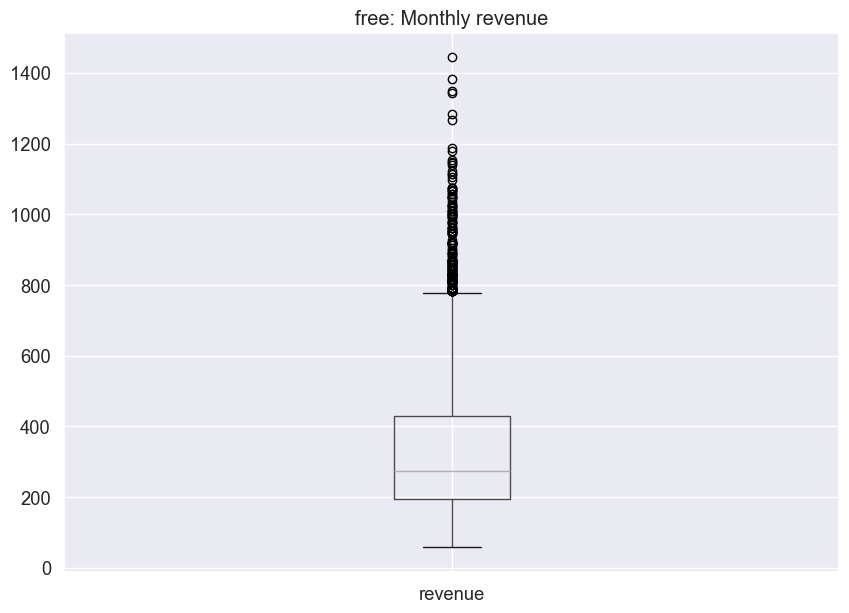

median: 274.0 
mean: 328.6 
min: 58.0 
max: 1444.0 
upper outlier threshold: 779.0 
lower outlier threshold: -157.0 
Q1: 194.0 
Q3: 428.0


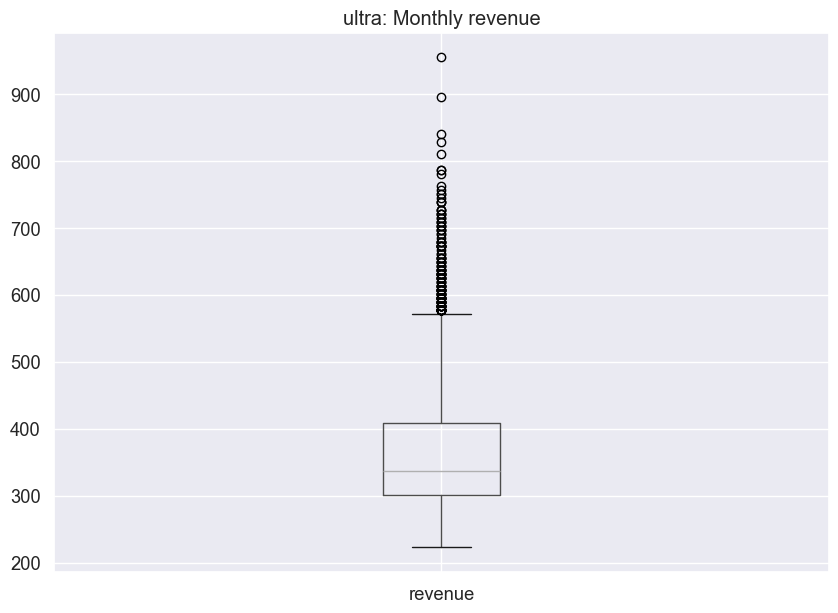

median: 337.0 
mean: 362.8 
min: 223.0 
max: 955.0 
upper outlier threshold: 571.0 
lower outlier threshold: 139.0 
Q1: 301.0 
Q3: 409.0


In [82]:
data_boxplot(all_users_pivot.query('subscription_fee == 0'), 
             'revenue', 
             'free: Monthly revenue')

data_boxplot(all_users_pivot.query('subscription_fee != 0'), 
             'revenue', 
             'ultra: Monthly revenue')

The median monthly revenue from subscribed users is 79 rubles higher, with the first and third quartiles also showing an upward difference. Clearly, subscribed users generate consistently higher revenue than non-subscribers.

For better visualization, let's plot both distributions on the same graph.

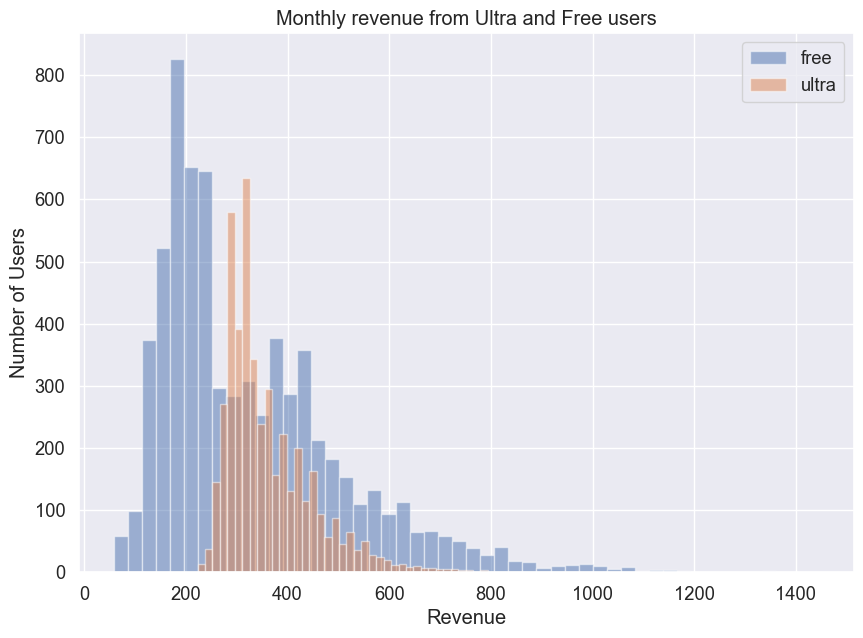

In [83]:
all_users_pivot.query('subscription_fee == 0')['revenue'].hist(alpha=0.5, label='free', bins = 50)
all_users_pivot.query('subscription_fee != 0')['revenue'].hist(alpha=0.5, label='ultra', bins = 50)

plt.title('Monthly revenue from Ultra and Free users')
plt.xlabel('Revenue')
plt.ylabel('Number of Users')
plt.legend()
plt.show()

## 6. Hypothesis Testing
### 6.1 Hypothesis 1. Duration

$H_0$: The average trip durations in both groups are the same.  
$H_1$: The average trip duration for `Ultra` users is higher.

We will use the previously created datasets free_users and ultra_users for comparison.
Earlier, we found that the number of trips made by subscription users is almost twice as low, which is a significant difference in sample sizes. Therefore, when conducting the t-test, we will set `equal_var = False`.
Since these samples are independent, we will use the appropriate test for analysis.

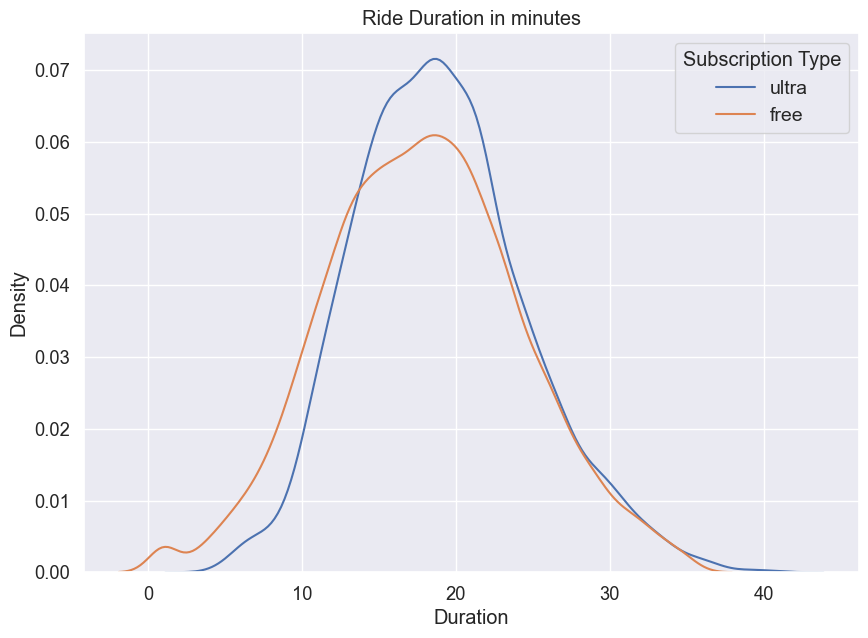

p-value: 1.1814679253701353e-36
Reject the null hypothesis


In [84]:
sns.kdeplot(ultra_users['duration'], label="ultra")
sns.kdeplot(free_users['duration'], label="free")

plt.title('Ride Duration in minutes')
plt.xlabel('Duration')
plt.legend(prop={'size': 14}, title = 'Subscription Type', loc="upper right")

plt.show()

results = st.ttest_ind(ultra_users['duration'], 
                       free_users['duration'], 
                       equal_var = False, 
                       alternative='greater')
alpha = 0.05

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Failed to reject the null hypothesis')


### 6.2. Hypothesis 2. Distance
3130 meters is the optimal trip distance considering scooter wear and tear. Earlier in our research, we noticed that Ultra users tend to take shorter trips. Now, let's test our colleagues' hypothesis.

$H_0$: The average trip distance for `Ultra` users is equal to 3130 meters.  
$H_1$: The average trip distance for `Ultra` users exceeds the optimal 3130 meters.

To test this hypothesis, we will use a one-sample t-test with the parameter `alternative='less'`.

In [85]:
perfect_distance = 3130

alpha = 0.05

results = st.ttest_1samp(
    ultra_users['distance'], 
    perfect_distance, alternative='greater')

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Failed to reject the null hypothesis')

p-value: 0.9195362605842414
Failed to reject the null hypothesis


We were unable to confirm the hypothesis that trips taken by subscribed users exceed an average distance of 3130 meters. Therefore, we can assume that Ultra users' trips do not lead to increased scooter wear and tear.

### 6.3. Hypothesis 3: Revenue
Which user group generates more revenue for the service?

$H_0$: The average monthly revenue from Ultra users is equal to that of `Free` users.  
$H_1$: The average monthly revenue from Ultra users is higher than that of `Free` users.

To test this hypothesis, we will use a t-test for two independent samples. Earlier in our research, we established that the number of trips made by subscribed users is almost half that of non-subscribed users. Therefore, we will set `equal_var = False` in our calculations.

In [86]:
free_users_pivot = all_users_pivot.query('subscription_fee == 0')
ultra_users_pivot = all_users_pivot.query('subscription_fee != 0')

# t-test:
results = st.ttest_ind(ultra_users_pivot['revenue'], 
                       free_users_pivot['revenue'],
                       equal_var = False,
                       alternative='greater')
alpha = 0.05

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Failed to reject the null hypothesis')

p-value: 8.874140893976874e-40
Reject the null hypothesis


We can reject the null hypothesis in favor of the assumption that the average monthly revenue from subscribed users is higher than that from non-subscribed users. Now, the key task is to motivate more users to subscribe! (:

### 6.4. Support Requests
To assess changes in the number of support requests after the server updates, we need to analyze two samples: the list of requests before the update and the list after. The appropriate analysis tool is a t-test for dependent samples, which will first need to be equalized in size.

Since we expect a significant decrease in the number of requests, we will use a one-tailed hypothesis test.

## 7. Calculation of Marketing Activities
### 7.1. Promo Codes for Subscription

The marketing department needs to determine how many promo codes for a free one-month subscription should be sent to users so that the probability of failing to meet the subscription renewal plan does not exceed 5%. It is expected that at least 100 people will renew their subscription. Experience from similar past campaigns has shown that 10% of users renew their subscription after the trial period.

The probability of failing to meet the plan does not exceed 0.05 
when the number of promo codes is 1161


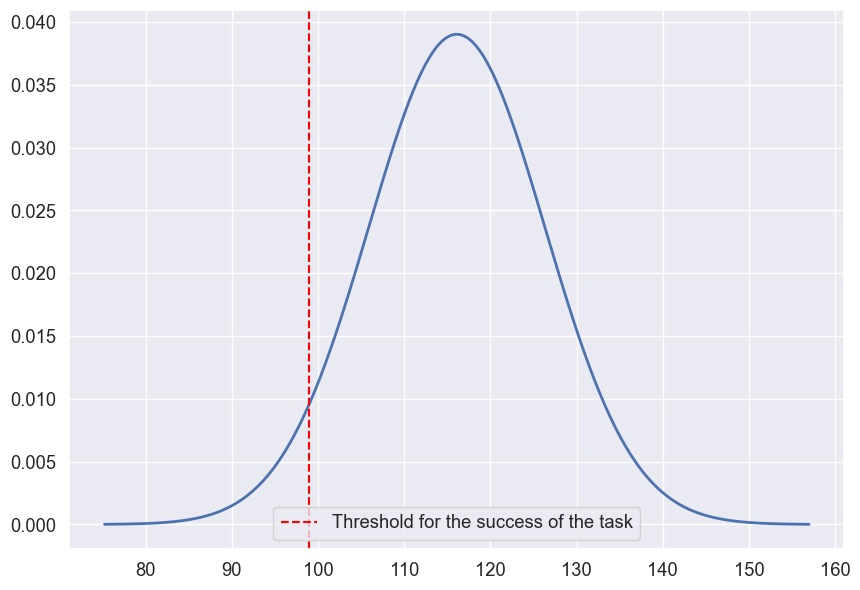

In [87]:
n = 1000
k = 99
p = 0.1

p_2 = 0.05

while p_2 < binom.cdf(k, n, p):
    n += 1

print(f"The probability of failing to meet the plan does not exceed {binom.cdf(k, n, p).round(2)} \n"
      f"when the number of promo codes is {n}")

mu = n * p
sigma = (n * p * (1 - p))**0.5
 
left = mu - 4 * sigma
right = mu + 4 * sigma
x = np.linspace(left, right, 1161)

theplot = plt.subplot()
theplot.plot(x, st.norm.pdf(x, mu, sigma), 'b-', lw=2)
plt.axvline (x=k, color='red', linestyle='--', label='Threshold for the success of the task')
plt.legend() 
plt.show()

### 7.2. Push Notification Sending

The marketing department plans to send 1,000,000 notifications. We know that about 40% of users open them. Let's plot an approximate distribution and assess the probability that no more than 399,500 users will open the notification.

Since the user behavior in this case follows a binomial distribution (either the push notification is opened or it is not), and we have a large number of observations, we will use the normal approximation to the binomial distribution and the `.cdf()` method.

The probability of opening the messages: 0.15371708296369768


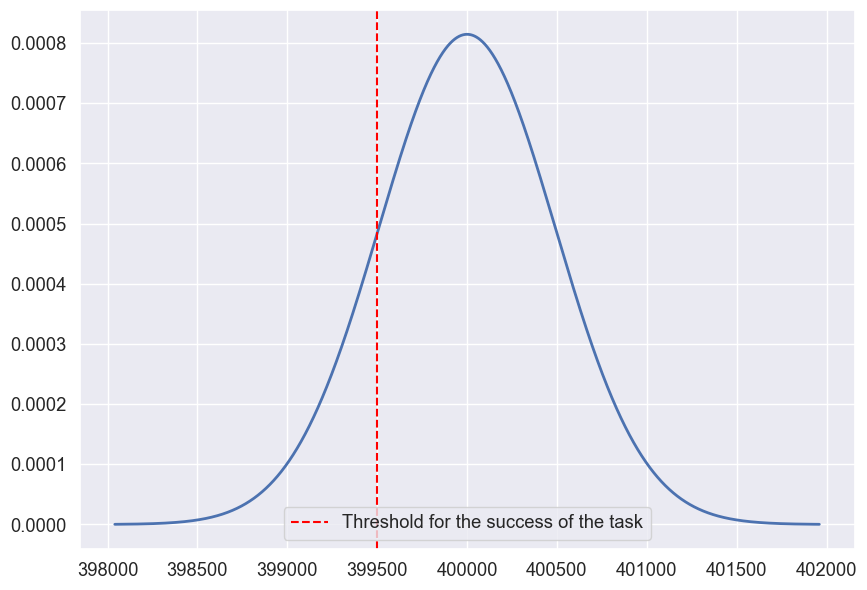

In [88]:
n = 1000000
p = 0.4
k = 399500

mu = n * p
sigma = (n * p * (1 - p))**0.5

distr = st.norm(mu, sigma)

result = distr.cdf(k)
print('The probability of opening the messages:', result)

left = mu - 4 * sigma
right = mu + 4 * sigma

x = np.linspace(left, right, 1000000)
theplot = plt.subplot()
theplot.plot(x, st.norm.pdf(x, mu, sigma), 'b-', lw=2)
plt.axvline (x=k, color='red', linestyle='--', label='Threshold for the success of the task')
plt.legend()

plt.show()

## 8. Conclusions
We found that the average age of our customers is 25 years old, with most users falling between 22 and 28 years old. Their average ride distance is just over 3 kilometers, with an average duration of 18 minutes. The majority of rides (in terms of duration) fall between 14 and 22 minutes. Additionally, having a subscription results in longer and more extended rides.
We also:

1. Tested three hypotheses from our colleagues:
* The average ride duration for ultra users is higher — this is true.
* The average ride distance for ultra users does not exceed the optimal 3130 meters — rides from subscription users do not cause more wear and tear on the scooters.
* The average monthly revenue for ultra users is higher than for free users — statistically significant confirmation of this hypothesis was obtained.

2. Determined the threshold values for marketing campaigns:
* We need to issue 1161 promo codes for the trial subscription to ensure that the probability of not meeting the subscription goal does not exceed 5%.
* The probability that no more than 399,500 of 1 million push notifications will be opened is 15.3%.

In conclusion, subscription is a profitable option for the service, as `ultra` users consistently provide higher monthly revenue: the median monthly revenue is **337 rubles** for ultra users compared to **258 rubles** for free users. The maximum monthly revenue (excluding outliers) is also higher for subscription users: **634 rubles** compared to **571 rubles** for free users.

Encouraging users to switch from the `free` to the `ultra` category will also contribute to less wear and tear on scooters. We discovered that the longest rides (excluding outliers) for subscription users are almost 1.5 kilometers shorter than those for free users (4.7 km vs. 6.2 km). There are also grounds to believe that, on average, subscription users' rides do not exceed the optimal distance of 3130 meters.

Additionally, `ultra` users have almost no super-short rides, which may indicate a low ride abandonment rate — an important factor for the business. A scooter that was abandoned after two minutes by a free user could have been used by a loyal customer.